# Set up environment

In [1]:
# !jupyter-nbconvert --to script gan_mlp_lstm.ipynb

In [2]:
import os

# make only specific GPU to be utilized
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

# select GPU to run on
GPU = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

# stop GPU
# os.environ["CUDA_VISIBLE_DEVICES"] ="-1"

# set GPU to be deterministic 
os.environ["PYTHONHASHSEED"] = "0" # set hash environment
os.environ["TF_CUDNN_USE_AUTOTUNE"] = "0" # use cuDNN function to retrieve the best algorithm
os.environ["TF_CUDNN_CONVOLUTION_BWD_FILTER_ALGO_DETERMINISTIC"]='1' # use cuDNN deterministic algorithms
os.environ['TF_DETERMINISTIC_OPS'] = '1' # deterministic setting

# set numpy, python, tensorflow random seed
from numpy.random import seed
import random
random.seed(10)
seed(10)
from tensorflow import set_random_seed
set_random_seed(20)

# GPU memory control
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True
config.gpu_options.per_process_gpu_memory_fraction = 0.25
sess = tf.Session(config=config)

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.
W0915 02:47:33.310903 140524951250752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:190: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0915 02:47:33.311892 140524951250752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:197: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W0915 02:47:33.312396 140524951250752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:203: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0915 02:47:33.315838 140524951250752 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:207: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15014755701209612524
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 13005521678935877712
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7055963194038980485
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4228513792
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13933620757772609289
physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:05.0, compute capability: 7.0"
]


In [5]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
# %matplotlib inline
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

from keras.layers import Dense, Dropout, Input, Reshape, Bidirectional, Embedding
from keras.layers import LSTM, Conv1D, BatchNormalization, Activation, MaxPooling1D, Flatten
from keras.models import Model,Sequential
from keras.datasets import mnist
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam, SGD, Adamax, RMSprop
from keras_ordered_neurons import ONLSTM
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.callbacks import CSVLogger 

from tqdm import tqdm, tqdm_notebook

# Import data

In [6]:
# !ls 

## train data

In [7]:
df_train = pd.read_csv("USDJPY/usdjpy_train.csv")
# df_train = pd.read_csv("9449_gmo_20180104-20190831.csv", thousands=',', dtype={'Open': float})
# df_train = pd.read_csv("rawdata/9449_gmointernet_daily_20160101_20161231.csv")

if "Date" in df_train.columns:
    df_train.sort_values("Date", inplace=True)
else:
    df_train.sort_values("datetime", inplace=True)   
df_train.head()
# df_train.dtypes

,datetime,Open
0,2018-01-02 10:00:00,112.37
1,2018-01-03 10:00:00,112.33
2,2018-01-04 10:00:00,112.61
3,2018-01-05 10:00:00,113.19
4,2018-01-08 10:00:00,113.22


## test data

In [8]:
df_test = pd.read_csv("USDJPY/usdjpy_test.csv")
# df_test = pd.read_csv("9449_gmo_20190101-20190831.csv", thousands=',')
# df_test = pd.read_csv("rawdata/9449_gmointernet_daily_20170101_20170630.csv")

if "Date" in df_test.columns:
    df_test.sort_values("Date", inplace=True)
else:
    df_test.sort_values("datetime", inplace=True)
df_test.head()

,datetime,Open
0,2019-01-01 10:00:00,109.59
1,2019-01-02 10:00:00,108.94
2,2019-01-03 10:00:00,107.63
3,2019-01-04 10:00:00,108.01
4,2019-01-07 10:00:00,108.19


# Process data and set up parameters

In [9]:
# set up batch_size
batch_size = 60 #60
lstm_batch_size =60 #60 #timestep
num_epoch = 100
selected_features = ["Open"] # ["Open", "Vol"] # the first column should be the one would like to predict

In [10]:
# process train data
data_train = df_train[selected_features].values 
print ("data_train", data_train.shape)

# calculate number of features
num_features = data_train.shape[1]
print ("num_features", num_features)

# normalise data
scaler_train = MinMaxScaler(feature_range = (0, 1))
data_train_scaled = scaler_train.fit_transform(data_train)
scaler_train_output = MinMaxScaler(feature_range = (0, 1))
data_train_scaled_output = scaler_train_output.fit_transform(data_train[:,0:1])

# convert data shape for lstm
train_features = []
labels = []
for i in range(lstm_batch_size, len(data_train)):
    train_features.append(data_train_scaled[i-lstm_batch_size:i, 0:data_train_scaled.shape[1]])
    labels.append(data_train_scaled[i, 0])

# reshape
train_features, labels = np.array(train_features), np.array(labels)
train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], data_train_scaled.shape[1]))
print ("train_features", train_features.shape)

data_train (259, 1)
num_features 1
train_features (199, 60, 1)


In [11]:
# process test data
data_total = pd.concat((df_train[selected_features], df_test[selected_features]), axis=0)
print ("data_total", data_total.shape)
data_test = data_total[len(data_total) - len(df_test) - lstm_batch_size + 1:].values
print ("data_test", data_test.shape)

# normalise data
scaler_test = MinMaxScaler(feature_range = (0, 1))
data_test_scaled = scaler_test.fit_transform(data_test)

# convert data shape for lstm
test_features = []
for i in range(lstm_batch_size, len(data_test)):
    test_features.append(data_test_scaled[i-lstm_batch_size:i, 0:data_test_scaled.shape[1]])
test_features = np.array(test_features)
test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], data_test_scaled.shape[1]))
print ("test_features", test_features.shape)

data_total (411, 1)
data_test (211, 1)
test_features (151, 60, 1)


In [12]:
def plot_timeseries(epoch, training_type, discriminator_type, generator_type, generated_timeseries, real_data, examples=100):
    plt.figure(figsize=(10,10))
    for i in range(generated_timeseries.T.shape[0]):
        ax1 = plt.subplot(3, 1, i+1)
        ax1.plot(generated_timeseries.T[0], color='r', label='predict')
        ax1.ticklabel_format(useOffset=False)
        ax2 = ax1.twinx()
        ax2.plot(real_data, color='b', label="real")
        ax2.ticklabel_format(useOffset=False)
        ax1.legend(loc = (.85,.9), frameon = False)
        ax2.legend( loc = (.85, .85), frameon = False)
        ax1.set_title('epoch={}'.format(epoch))
        #print ("generated_timeseries", generated_timeseries)
        #print ("real_data", real_data)
    plt.tight_layout()
    plt.savefig('output/tuning_%s_%s_%s_generated_timeseries_%d.png' %(training_type, discriminator_type, generator_type, epoch))
    #plt.close()

In [13]:
def fit_performance(lstm_model, lstm_history, train_features, test_features):
    # plot history
    plt.plot(lstm_history.history['loss'], label='train')
    plt.legend()
    plt.show()    
    # train
    train_lstm_predict = lstm_model.predict(train_features)
    print (train_lstm_predict.shape, train_features.shape)
    train_lstm_predict = scaler_train_output.inverse_transform(train_lstm_predict)
    plot_timeseries(0, "train", "none", "lstm", train_lstm_predict, df_train.iloc[lstm_batch_size:, 1:2].values)
    # test
    lstm_predictions = lstm_model.predict(test_features)
    lstm_predictions = scaler_train_output.inverse_transform(lstm_predictions)
    plot_timeseries(0, "test", "none", "lstm", lstm_predictions, df_test.iloc[:, 1:2].values)
    return train_lstm_predict, lstm_predictions

# LSTM

In [14]:
# https://stackabuse.com/time-series-analysis-with-lstm-using-pythons-keras-library/

# LSTM - Model tuning

## LSTM1

In [15]:
# lstm_model
def create_lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error')

    return lstm_model
lstm_model = create_lstm_model()
lstm_model.summary()

W0907 04:42:55.454568 140540361324352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0907 04:42:55.769195 140540361324352 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3733: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0907 04:42:56.440891 140540361324352 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 60, 50)            10400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 60, 50)            20200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 60, 50)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)               

In [16]:
lstm_history = lstm_model.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
# lstm_history = lstm_model.fit(train_features, labels, epochs=100, batch_size=32, verbose=1, shuffle=False,
#                               callbacks=[ReduceLROnPlateau(factor=0.67, patience=3, verbose=1, min_lr=1E-5),
#                                          EarlyStopping(patience=200, verbose=1)])

W0907 04:42:56.691952 140540361324352 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/100
199/199 [==============================] - 4s 22ms/step - loss: 0.2308
Epoch 2/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0648
Epoch 3/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0433
Epoch 4/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0181
Epoch 5/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0339
Epoch 6/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0257
Epoch 7/100
199/199 [==============================] - 1s 7ms/step - loss: 0.0267
Epoch 8/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0166
Epoch 9/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0327
Epoch 10/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0166
Epoch 11/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0320
Epoch 12/100
199/199 [==============================] - 1s 6ms/step - loss: 0.0269
Epoch 13/100

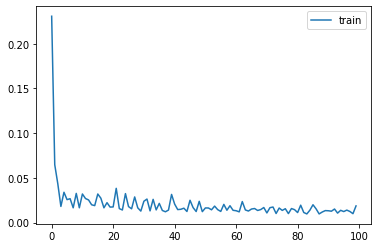

(199, 1) (199, 60, 1)


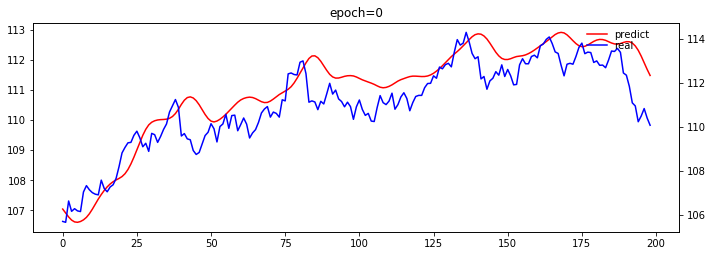

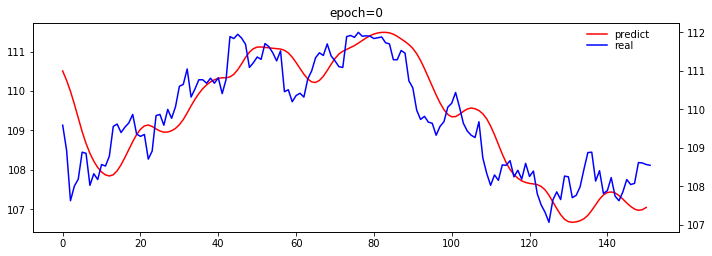

In [17]:
lstm_train_predict1, lstm_test_predict1 = fit_performance(lstm_model, lstm_history, train_features, test_features)

## LSTM2

Epoch 1/100
199/199 [==============================] - 4s 22ms/step - loss: 0.2920
Epoch 2/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0670
Epoch 3/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0115
Epoch 4/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0118
Epoch 5/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0117
Epoch 6/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0234
Epoch 7/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0170
Epoch 8/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0240
Epoch 9/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0112
Epoch 10/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0379
Epoch 11/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0252
Epoch 12/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0122
Epoch 13/100

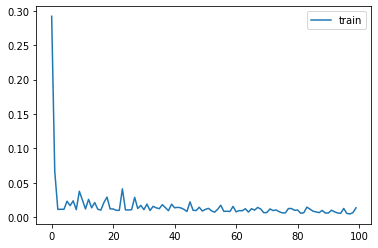

(199, 1) (199, 60, 1)


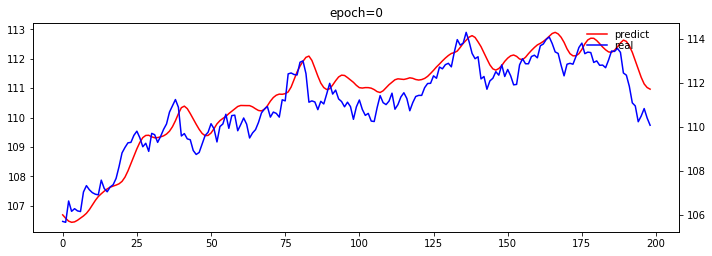

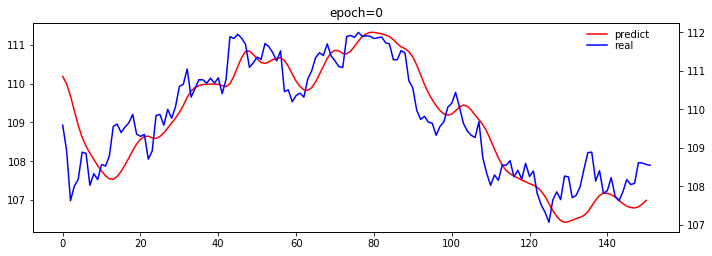

In [18]:
# lstm_model
def create_lstm_model2():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
#     lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=True))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50, return_sequences=True))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error')

    return lstm_model
lstm_model2 = create_lstm_model2()
# lstm_model.summary()
lstm_history2 = lstm_model2.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict2, lstm_test_predict2 = fit_performance(lstm_model2, lstm_history2, train_features, test_features)

## LSTM3

Epoch 1/100
199/199 [==============================] - 3s 14ms/step - loss: 0.1765
Epoch 2/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0104
Epoch 3/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0092
Epoch 4/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0150
Epoch 5/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0177
Epoch 6/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0085
Epoch 7/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0078
Epoch 8/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0111
Epoch 9/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0149
Epoch 10/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0093
Epoch 11/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0091
Epoch 12/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0075
Epoch 13/100

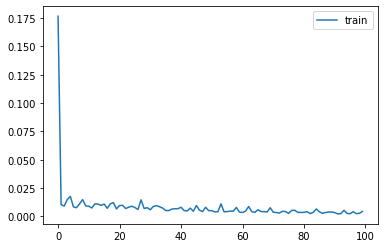

(199, 1) (199, 60, 1)


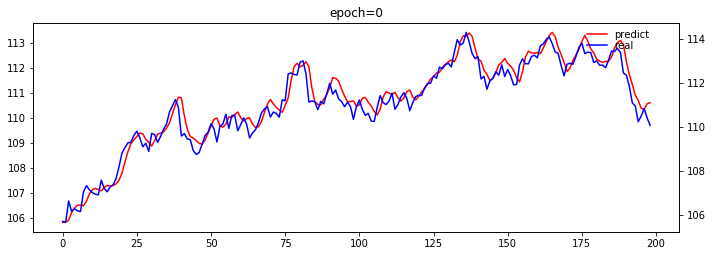

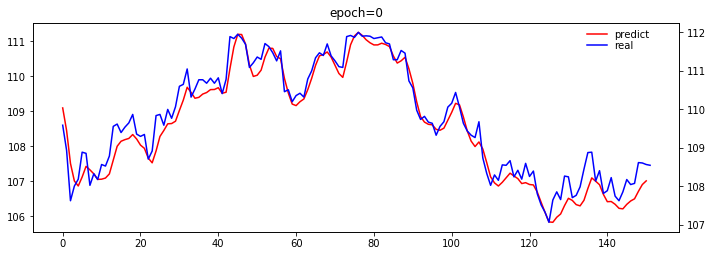

In [19]:
# lstm_model
def create_lstm_model3():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
#     lstm_model.add(Dropout(0.2))
#     lstm_model.add(LSTM(units=50, return_sequences=True))
#     lstm_model.add(Dropout(0.2))

#     lstm_model.add(LSTM(units=50, return_sequences=True))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error')

    return lstm_model
lstm_model3 = create_lstm_model3()
# lstm_model.summary()
lstm_history3 = lstm_model3.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict3, lstm_test_predict3 = fit_performance(lstm_model3, lstm_history3, train_features, test_features)

## LSTM4

Epoch 1/100
199/199 [==============================] - 3s 14ms/step - loss: 0.3551
Epoch 2/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0208
Epoch 3/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0150
Epoch 4/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 5/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0101
Epoch 6/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0150
Epoch 7/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0087
Epoch 8/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0116
Epoch 9/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0247
Epoch 10/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0091
Epoch 11/100
199/199 [==============================] - 1s 4ms/step - loss: 0.0081
Epoch 12/100
199/199 [==============================] - 1s 5ms/step - loss: 0.0085
Epoch 13/100

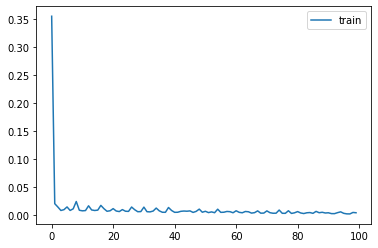

(199, 1) (199, 60, 1)


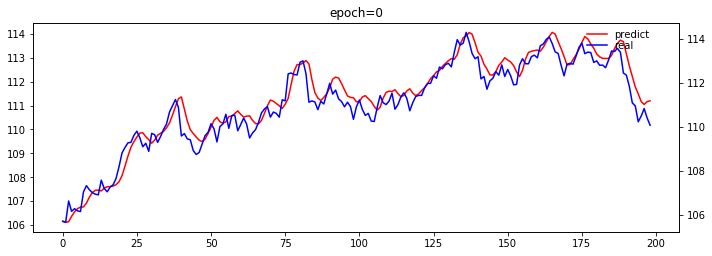

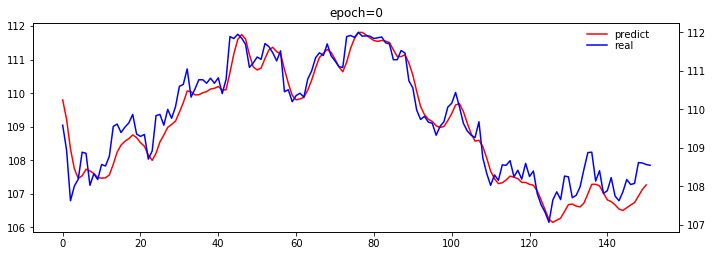

In [20]:
# lstm_model
def create_lstm_model4():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
#     lstm_model.add(Dropout(0.2))
#     lstm_model.add(LSTM(units=50, return_sequences=True))
#     lstm_model.add(Dropout(0.2))

#     lstm_model.add(LSTM(units=50, return_sequences=True))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50))
#     lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error')

    return lstm_model
lstm_model4 = create_lstm_model4()
# lstm_model.summary()
lstm_history4 = lstm_model4.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict4, lstm_test_predict4 = fit_performance(lstm_model4, lstm_history4, train_features, test_features)

## LSTM5

Epoch 1/100
199/199 [==============================] - 6s 28ms/step - loss: 0.4935
Epoch 2/100
199/199 [==============================] - 2s 10ms/step - loss: 0.3872
Epoch 3/100
199/199 [==============================] - 2s 10ms/step - loss: 0.2266
Epoch 4/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0503
Epoch 5/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0273
Epoch 6/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0456
Epoch 7/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0540
Epoch 8/100
199/199 [==============================] - 2s 9ms/step - loss: 0.1029
Epoch 9/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0339
Epoch 10/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0374
Epoch 11/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0534
Epoch 12/100
199/199 [==============================] - 2s 10ms/step - loss: 0.0183
Epoch

199/199 [==============================] - 2s 10ms/step - loss: 0.0174
Epoch 100/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0138


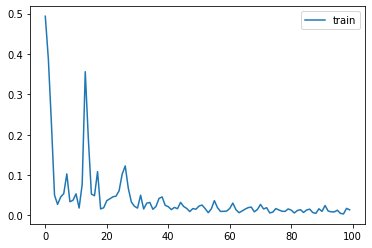

(199, 1) (199, 60, 1)


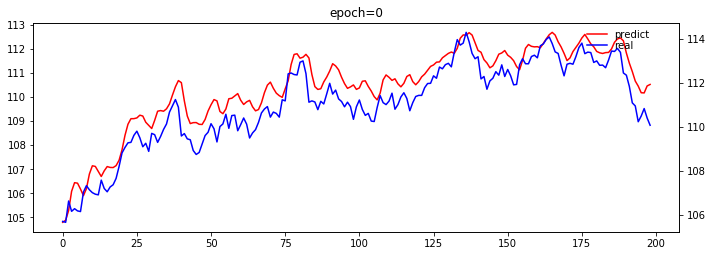

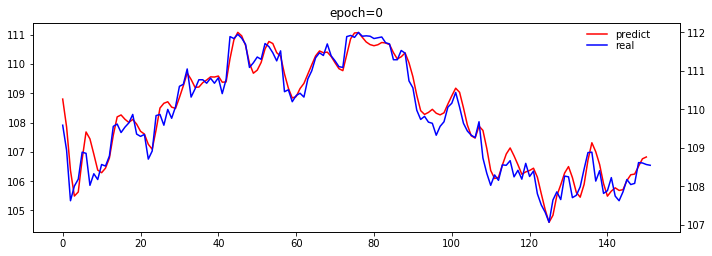

In [21]:
# lstm_model
def create_lstm_model5():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=500, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=500, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=500))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error')

    return lstm_model
lstm_model5 = create_lstm_model5()
# lstm_model.summary()
lstm_history5 = lstm_model5.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict5, lstm_test_predict5 = fit_performance(lstm_model5, lstm_history5, train_features, test_features)

## LSTM6

Epoch 1/100
199/199 [==============================] - 8s 40ms/step - loss: 0.3348
Epoch 2/100
199/199 [==============================] - 3s 13ms/step - loss: 0.0872
Epoch 3/100
199/199 [==============================] - 3s 14ms/step - loss: 0.0202
Epoch 4/100
199/199 [==============================] - 3s 14ms/step - loss: 0.0187
Epoch 5/100
199/199 [==============================] - 3s 14ms/step - loss: 0.0206
Epoch 6/100
199/199 [==============================] - 3s 13ms/step - loss: 0.0192
Epoch 7/100
199/199 [==============================] - 3s 13ms/step - loss: 0.0220
Epoch 8/100
199/199 [==============================] - 3s 14ms/step - loss: 0.0231
Epoch 9/100
199/199 [==============================] - 3s 14ms/step - loss: 0.0415
Epoch 10/100
199/199 [==============================] - 3s 14ms/step - loss: 0.0304
Epoch 11/100
199/199 [==============================] - 3s 14ms/step - loss: 0.0305
Epoch 12/100
199/199 [==============================] - 3s 13ms/step - loss: 0.0254
E

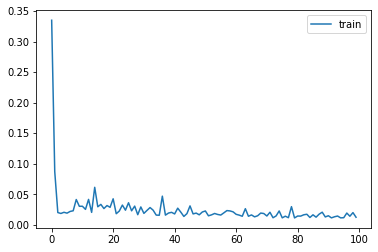

(199, 1) (199, 60, 1)


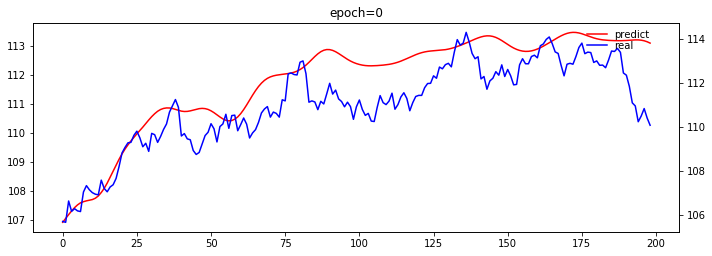

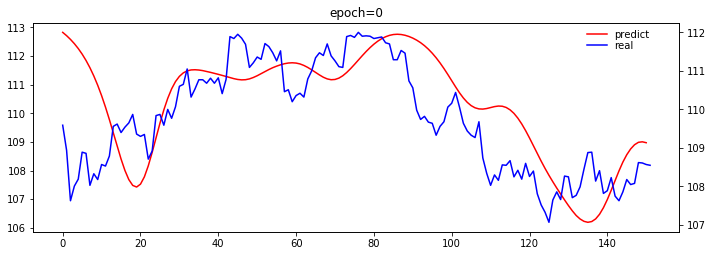

In [22]:
# lstm_model
def create_lstm_model6():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=True))
    lstm_model.add(Dropout(0.2))
    lstm_model.add(LSTM(units=50, return_sequences=True))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(LSTM(units=50))
    lstm_model.add(Dropout(0.2))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error')

    return lstm_model
lstm_model6 = create_lstm_model6()
# lstm_model.summary()
lstm_history6 = lstm_model6.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict6, lstm_test_predict6 = fit_performance(lstm_model6, lstm_history6, train_features, test_features)

## LSTM7

Epoch 1/100
199/199 [==============================] - 6s 32ms/step - loss: 0.9264 - acc: 0.0000e+00
Epoch 2/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0989 - acc: 0.0000e+00
Epoch 3/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0114 - acc: 0.0050
Epoch 4/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0126 - acc: 0.0050
Epoch 5/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0116 - acc: 0.0050
Epoch 6/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0155 - acc: 0.0050
Epoch 7/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0118 - acc: 0.0050
Epoch 8/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0173 - acc: 0.0050
Epoch 9/100
199/199 [==============================] - 2s 8ms/step - loss: 0.0190 - acc: 0.0050
Epoch 10/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0354 - acc: 0.0050
Epoch 11/100
199/199 [========

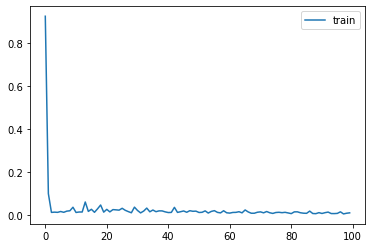

(199, 1) (199, 60, 1)


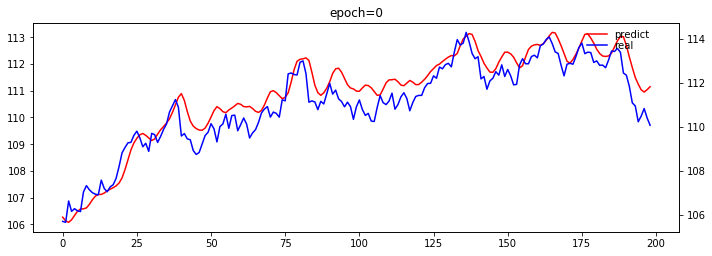

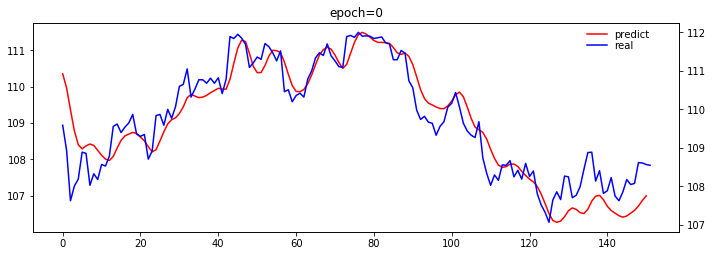

In [23]:
# lstm_model
def create_lstm_model7():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.01))
    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=100))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(Dense(units = 1))

    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=["accuracy"])

    return lstm_model
lstm_model7 = create_lstm_model7()
# lstm_model.summary()
lstm_history7 = lstm_model7.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict7, lstm_test_predict7 = fit_performance(lstm_model7, lstm_history7, train_features, test_features)

Epoch 1/100
199/199 [==============================] - 7s 35ms/step - loss: 1.1162 - acc: 0.0000e+00
Epoch 2/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0835 - acc: 0.0050
Epoch 3/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0116 - acc: 0.0050
Epoch 4/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0111 - acc: 0.0050
Epoch 5/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0112 - acc: 0.0050
Epoch 6/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0160 - acc: 0.0050
Epoch 7/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0108 - acc: 0.0050
Epoch 8/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0221 - acc: 0.0050
Epoch 9/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0105 - acc: 0.0050
Epoch 10/100
199/199 [==============================] - 2s 9ms/step - loss: 0.0129 - acc: 0.0050
Epoch 11/100
199/199 [============

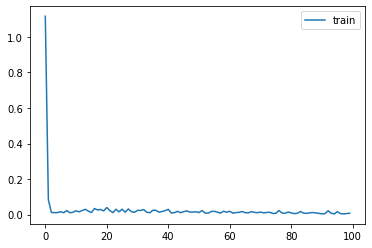

(199, 1) (199, 60, 1)


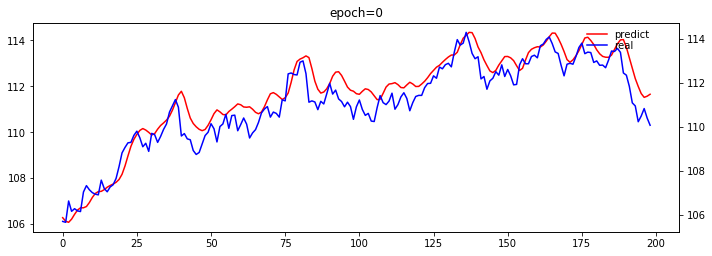

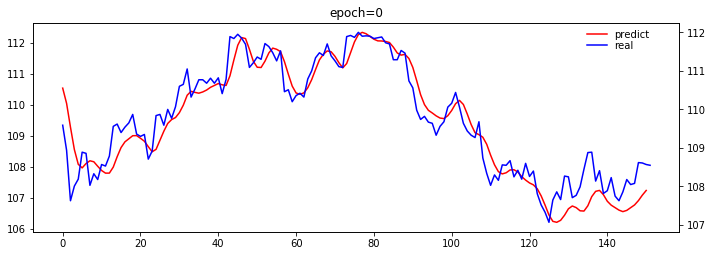

In [24]:
def create_lstm_model8():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.01))
    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=100))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(Dense(units = 1))
    lstm_model.add(Activation("linear"))
    
    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=["accuracy"])

    return lstm_model
lstm_model8 = create_lstm_model8()
# lstm_model.summary()
lstm_history8 = lstm_model8.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict8, lstm_test_predict8 = fit_performance(lstm_model8, lstm_history8, train_features, test_features)

Epoch 1/100
199/199 [==============================] - 1s 5ms/step - loss: 0.2992 - acc: 0.0000e+00
Epoch 2/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2817 - acc: 0.0000e+00
Epoch 3/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2688 - acc: 0.0000e+00
Epoch 4/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2579 - acc: 0.0000e+00
Epoch 5/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2480 - acc: 0.0000e+00
Epoch 6/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2385 - acc: 0.0000e+00
Epoch 7/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2290 - acc: 0.0000e+00
Epoch 8/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2202 - acc: 0.0000e+00
Epoch 9/100
199/199 [==============================] - 0s 2ms/step - loss: 0.2112 - acc: 0.0000e+00
Epoch 10/100
199/199 [==============================] - 1s 3ms/step - loss: 0.2026 - acc: 0.0000e+00

199/199 [==============================] - 0s 2ms/step - loss: 0.0068 - acc: 0.0050
Epoch 85/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0066 - acc: 0.0050
Epoch 86/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0065 - acc: 0.0050
Epoch 87/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0064 - acc: 0.0050
Epoch 88/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0063 - acc: 0.0050
Epoch 89/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0062 - acc: 0.0050
Epoch 90/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0061 - acc: 0.0050
Epoch 91/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0060 - acc: 0.0050
Epoch 92/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0059 - acc: 0.0050
Epoch 93/100
199/199 [==============================] - 0s 2ms/step - loss: 0.0059 - acc: 0.0050
Epoch 94/100
199/199 [=====================

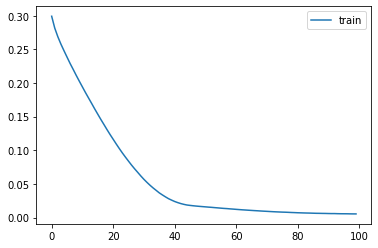

(199, 1) (199, 60, 1)


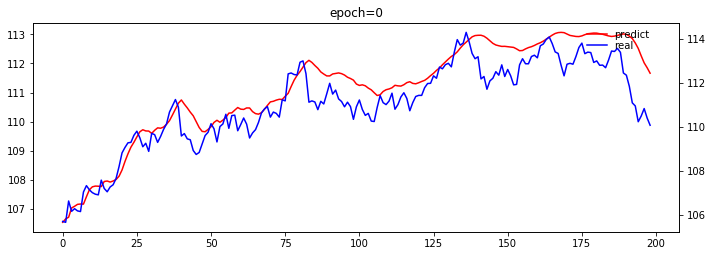

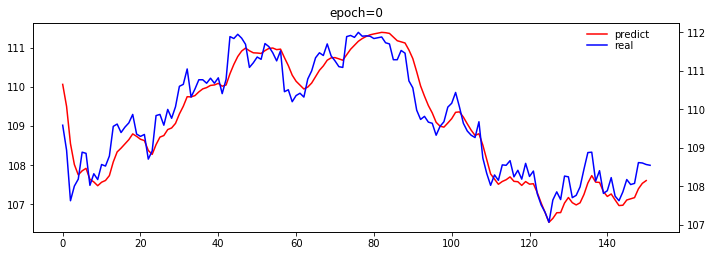

In [15]:
def create_lstm_model9():
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=1, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dense(units = 1))
    lstm_model.add(Activation("linear"))
    
    lstm_model.compile(optimizer = 'RMSprop', 
                       loss = 'mean_squared_error', metrics=["accuracy"])

    return lstm_model
lstm_model9 = create_lstm_model9()
# lstm_model.summary()
lstm_history9 = lstm_model9.fit(train_features, labels, epochs = num_epoch, batch_size = batch_size)
lstm_train_predict9, lstm_test_predict9 = fit_performance(lstm_model9, lstm_history9, train_features, test_features)

## Correlation

In [17]:
true = df_test.iloc[1:, 1:2].values
def accuracy_evaluation(method, true, prediction):
    # mean absolute error
    mae = mean_absolute_error(true, prediction)
    # mean absolute percentage error
    mape = np.mean(np.abs((true - prediction) / true)) * 100
    # root mean square error
    rmse = np.sqrt(mean_squared_error(true, prediction))
    # correlation coefficient
    corr = np.corrcoef(np.concatenate((true.T, prediction.T), axis=0))[0,1]
    print ("{}:\tmae:{:.5}\tmape:{:.5}\trmse:{:.5}\tcorr:{:.3}".format(method, mae, mape, rmse, corr))
    return

In [26]:
accuracy_evaluation("lstm1\t", true, lstm_test_predict1)
accuracy_evaluation("lstm2\t", true, lstm_test_predict2)
accuracy_evaluation("lstm3\t", true, lstm_test_predict3)
accuracy_evaluation("lstm4\t", true, lstm_test_predict4)
accuracy_evaluation("lstm5\t", true, lstm_test_predict5)
accuracy_evaluation("lstm6\t", true, lstm_test_predict6)
accuracy_evaluation("lstm7\t", true, lstm_test_predict7)
accuracy_evaluation("lstm8\t", true, lstm_test_predict8)

lstm1	:	mae:0.76627	mape:0.69894	rmse:0.92308	corr:0.841
lstm2	:	mae:0.86621	mape:0.78965	rmse:1.03	corr:0.866
lstm3	:	mae:1.2005	mape:1.0954	rmse:1.3007	corr:0.945
lstm4	:	mae:0.79395	mape:0.72598	rmse:0.95235	corr:0.934
lstm5	:	mae:1.4888	mape:1.3598	rmse:1.6191	corr:0.942
lstm6	:	mae:1.1833	mape:1.0832	rmse:1.5454	corr:0.65
lstm7	:	mae:0.82708	mape:0.75484	rmse:0.99223	corr:0.889
lstm8	:	mae:0.68594	mape:0.62765	rmse:0.86932	corr:0.914


In [18]:
accuracy_evaluation("lstm9\t", true, lstm_test_predict9)

lstm9	:	mae:0.75863	mape:0.69141	rmse:0.87193	corr:0.922


# LSTM hyperparameter tuning

In [27]:
# https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
# https://qiita.com/cvusk/items/285e2b02b0950537b65e

In [28]:
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [29]:
def create_lstm_model9(optimizer='RMSprop', loss='mean_squared_error',
                      activation='linear'):
    lstm_model = Sequential()
    lstm_model.add(LSTM(units=100, return_sequences=True, input_shape=(train_features.shape[1], train_features.shape[2])))
    lstm_model.add(Dropout(0.01))
    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=100, return_sequences=True))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(LSTM(units=100))
    lstm_model.add(Dropout(0.01))

    lstm_model.add(Dense(units = 1))
    lstm_model.add(Activation(activation))
    
    lstm_model.compile(optimizer = optimizer, loss = loss, metrics=["accuracy"])

    return lstm_model

In [30]:
# Select model to be tuned
selected_model = create_lstm_model9
# selected_model.fit(X_train, Y_train, epochs = 1, batch_size = 50)
print (lstm_model7, selected_model)

<keras.engine.sequential.Sequential object at 0x7fcedb206780> <function create_lstm_model9 at 0x7fced590a7b8>


In [31]:
train_features.shape

(199, 60, 1)

In [32]:
# Dplit data into input (X) and outptu (Y)
X_train = train_features
Y_train = labels
print (X_train.shape, Y_train.shape)

(199, 60, 1) (199,)


In [33]:
# Define options for parameters
# activation = ["linear", "relu", "sigmoid"]
# optimizer = ["adam", "adagrad", "RMSprop"]
activation = ["linear"]
optimizer = ["RMSprop"]
num_epoch = [50, 100]#[50, 100, 200]
batch_size = [60]#[60, 100, 200]

In [34]:
# Retrieve model and parameter into GridSearchCV
# Create model
model = KerasClassifier(build_fn=selected_model, nb_epoch=2, verbose=0)

# Create parameter dictionary
param_grid = dict(batch_size=batch_size,
                  epochs=num_epoch,
                  activation=activation,
                  optimizer=optimizer)

# Set up grid
grid = GridSearchCV(model, param_grid=param_grid)

# Run grid search
grid_result = grid.fit(X_train, Y_train)

# Get the best score and the optimised mode
print (grid_result.best_score_)
print (grid_result.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


0.0
{'activation': 'linear', 'batch_size': 60, 'epochs': 50, 'optimizer': 'RMSprop'}


In [35]:
# Summarise results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.000000 (0.000000) with: {'activation': 'linear', 'batch_size': 60, 'epochs': 50, 'optimizer': 'RMSprop'}
0.000000 (0.000000) with: {'activation': 'linear', 'batch_size': 60, 'epochs': 100, 'optimizer': 'RMSprop'}


In [36]:
# Define options for parameters
activation = ["linear", "relu", "sigmoid"]
optimizer = ["adam", "RMSprop"]
num_epoch = [100]
batch_size = [60]

In [37]:
# Retrieve model and parameter into GridSearchCV
# create model
model = KerasClassifier(build_fn=selected_model, nb_epoch=2, verbose=0)

# create parameter dictionary
param_grid = dict(batch_size=batch_size,
                  epochs=num_epoch,
                  activation=activation,
                  optimizer=optimizer)

# set up grid
grid = GridSearchCV(model, param_grid=param_grid)

# Run grid search
grid_result = grid.fit(X_train, Y_train)

# Get the best score and the optimised mode
print (grid_result.best_score_)
print (grid_result.best_params_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


0.26633165245080115
{'activation': 'relu', 'batch_size': 60, 'epochs': 100, 'optimizer': 'RMSprop'}


In [38]:
# Summarise results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

0.000000 (0.000000) with: {'activation': 'linear', 'batch_size': 60, 'epochs': 100, 'optimizer': 'adam'}
0.000000 (0.000000) with: {'activation': 'linear', 'batch_size': 60, 'epochs': 100, 'optimizer': 'RMSprop'}
0.000000 (0.000000) with: {'activation': 'relu', 'batch_size': 60, 'epochs': 100, 'optimizer': 'adam'}
0.266332 (0.373828) with: {'activation': 'relu', 'batch_size': 60, 'epochs': 100, 'optimizer': 'RMSprop'}
0.030151 (0.042320) with: {'activation': 'sigmoid', 'batch_size': 60, 'epochs': 100, 'optimizer': 'adam'}
0.030151 (0.042320) with: {'activation': 'sigmoid', 'batch_size': 60, 'epochs': 100, 'optimizer': 'RMSprop'}
